The key idea of image generation is to develop a low-dimensional latent space of representations (which, like everything else in deep learning, is a vector space), where any
point can be mapped to a “valid” image: an image that looks like the real thing.

The
module capable of realizing this mapping, taking as input a latent point and outputting an image (a grid of pixels), is called a generator (in the case of GANs) or a decoder
(in the case of VAEs).


Once such a latent space has been learned, you can sample
points from it, and, by mapping them back to image space, generate images that have
never been seen before . These new images are the in-betweens of
the training images.

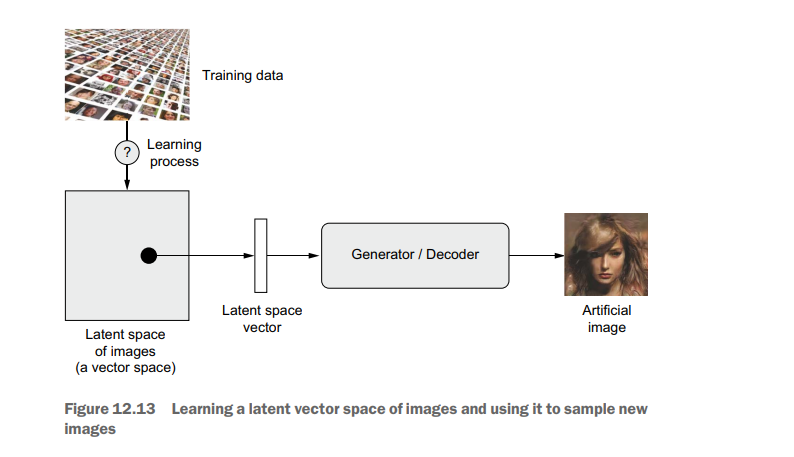

 GANs and VAEs are two different strategies for learning such latent spaces of
image representations, each with its own characteristics. VAEs are great for learning latent spaces that are well structured, where specific directions encode a meaningful
axis of variation in the data. GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much
structure and continuity

[Difference between GANs and VAEs](https://chat.openai.com/share/67314bc1-5cef-4c1c-b6f7-6ee67684c6cf)

[How VAE works](https://chat.openai.com/share/7b7d5823-d1f4-4585-abc3-151940b8ae6b)

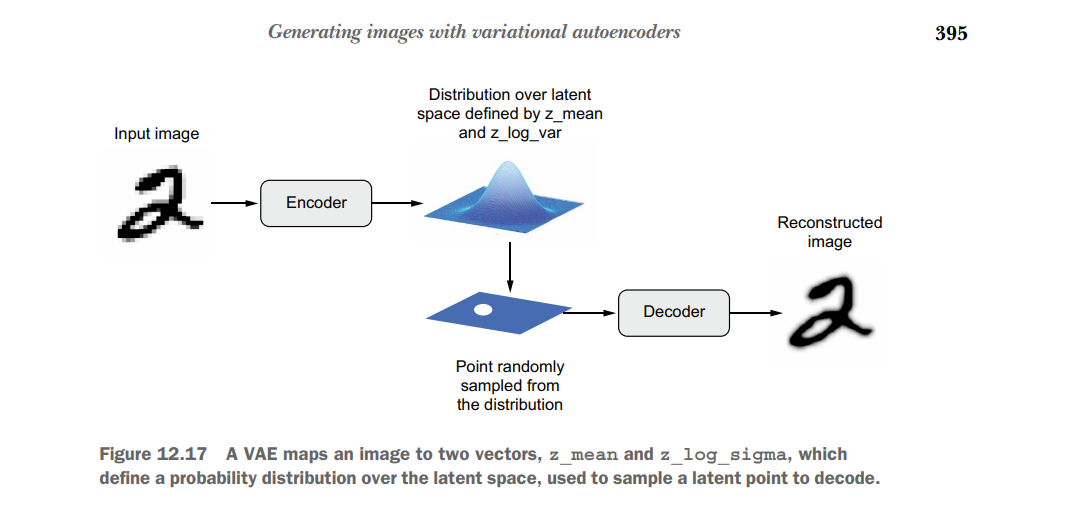

[Continuity in latent space in VAE](https://chat.openai.com/share/07ff545e-1e11-43e3-a288-45912901ba86)

#  Implementing a VAE with Keras

We’re going to be implementing a VAE that can generate MNIST digits. It’s going to
have three parts:


 An encoder network that turns a real image into a mean and a variance in the
latent space

 A sampling layer that takes such a mean and variance, and uses them to sample
a random point from the latent space

 A decoder network that turns points from the latent space back into images

The following listing shows the encoder network we’ll use, mapping images to the
parameters of a probability distribution over the latent space.

It’s a simple convnet
that maps the input image x to two vectors, z_mean and z_log_var.

One important
detail is that we use strides for downsampling feature maps instead of max pooling.

 Recall
that, in general, strides are preferable to max pooling for any model that cares about
information location—that is to say, where stuff is in the image—and this one does, since
it will have to produce an image encoding that can be used to reconstruct a valid
image.

In [ ]:
# VAE encoder network

from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2 # Dimensionality of the latent space: a 2D plane

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# The input image ends up being encoded into these two parameters.
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

Next is the code for using z_mean and z_log_var, the parameters of the statistical distribution assumed to have produced input_img, to generate a latent space point z.


In [ ]:
import tensorflow as tf
class Sampler(layers.Layer):
 def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size)) # Draw a batch of random normal vectors.
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Apply the VAE sampling formula.

The following listing shows the decoder implementation. We reshape the vector z to
the dimensions of an image and then use a few convolution layers to obtain a final
image output that has the same dimensions as the original input_img.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,)) # Input where we’ll feed z
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) # Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder
x = layers.Reshape((7, 7, 64))(x) # Revert the Flatten layer of the encoder.

# Revert the Conv2D layers of the encoder.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x) # The output ends up with shape (28, 28, 1).
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

Now let’s create the VAE model itself. This is your first example of a model that isn’t
doing supervised learning (an autoencoder is an example of self-supervised learning,
because it uses its inputs as targets). Whenever you depart from classic supervised
learning, it’s common to subclass the Model class and implement a custom train_
step() to specify the new training logic

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()

    # We use these metrics to keep track of the loss averages over each epoch.

    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self): # We list the metrics in the metrics property to enable the model to reset them after each epoch (or between multiple calls to fit()/evaluate()).
    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler(z_mean, z_log_var)
      reconstruction = decoder(z)
      # We sum the reconstruction loss over the spatial dimensions (axes 1 and 2) and take its mean over the batch dimension.
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2)))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Add the regularization term (Kullback–Leibler divergence).
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
      "total_loss": self.total_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_loss_tracker.result(),
      "kl_loss": self.kl_loss_tracker.result(),
    }

Finally, we’re ready to instantiate and train the model on MNIST digits. Because the
loss is taken care of in the custom layer, we don’t specify an external loss at compile
time (loss=None), which in turn means we won’t pass target data during training (as
you can see, we only pass x_train to the model in fit()).

In [ ]:
import numpy as np
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True) # Note that we don’t pass a loss argument in compile(), since the loss is already part of the train_step()
vae.fit(mnist_digits, epochs=30, batch_size=128) # Note that we don’t pass targets in fit(), since train_step() doesn’t expect any.

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30


547/547 [==============================] - 51s 68ms/step - total_loss: 208.9397 - reconstruction_loss: 206.4783 - kl_loss: 2.4610
Epoch 2/30
547/547 [==============================] - 31s 56ms/step - total_loss: 171.8580 - reconstruction_loss: 168.2732 - kl_loss: 3.5849
Epoch 3/30
547/547 [==============================] - 30s 55ms/step - total_loss: 165.0580 - reconstruction_loss: 161.4437 - kl_loss: 3.6144
Epoch 4/30
547/547 [==============================] - 33s 61ms/step - total_loss: 161.2256 - reconstruction_loss: 157.5325 - kl_loss: 3.6931
Epoch 5/30
547/547 [==============================] - 30s 55ms/step - total_loss: 158.7045 - reconstruction_loss: 154.9582 - kl_loss: 3.7463
Epoch 6/30
547/547 [==============================] - 30s 56ms/step - total_loss: 156.9429 - reconstruction_loss: 153.1568 - kl_loss: 3.7859
Epoch 7/30
547/547 [==============================] - 30s 54ms/step - total_loss: 155.4112 - reconstruction_loss: 151.5989 - kl_loss: 3.8123
Epoch 8/30
547/547 [====

Once the model is trained, we can use the decoder network to turn arbitrary latent
space vectors into images.

1/1 [==============================] - 0s 16ms/step


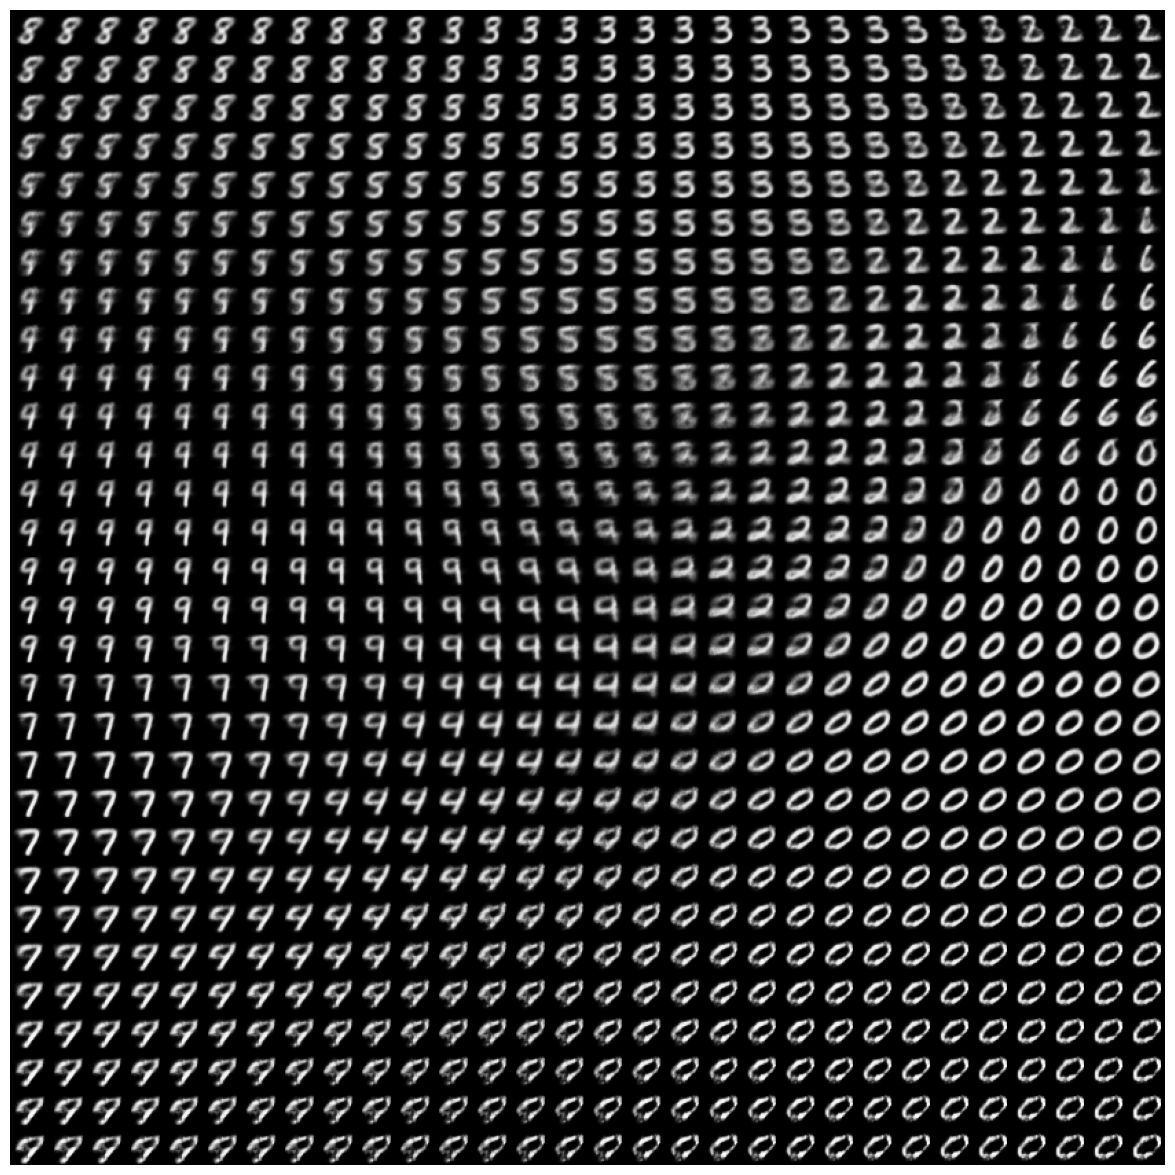

In [ ]:
import matplotlib.pyplot as plt
n = 30 # We’ll display a grid of 30 × 30 digits (900 digits total).
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample points linearly on a 2D grid.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y): # Iterate over grid locations.
  for j, xi in enumerate(grid_x):
    # For each location, sample a digit and add it to our figure.
    z_sample = np.array([[xi, yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[ i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a
path through latent space.

Specific directions in this space have a meaning: for example, there are directions for “five-ness,” “one-ness,” and so on.

Wrapping up

 Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images.
There are two major tools to do this: VAEs and GANs.


 VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face
swapping, turning a frowning face into a smiling face, and so on. They also work
nicely for doing latent-space-based animations, such as animating a walk along a
cross section of the latent space or showing a starting image slowly morphing
into different images in a continuous way.


 GANs enable the generation of realistic single-frame images but may not induce
latent spaces with solid structure and high continuity.